In [1]:
# Keras for mnist datasat
from keras.datasets import mnist

# NumPy for data processing and handling
import numpy as np

# PyTorch for neural networks
import torch

# MatPlotLib for plotting
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
# Load MNIST dataset from Keras
(train_x, train_y), (test_x, test_labels) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
# Reshaping data and separate train and validation sets
train_inputs = np.reshape(train_x[:-5000], (train_x[:-5000].shape[0], 28*28)) / 255.0
val_inputs = np.reshape(train_x[-5000:], (train_x[-5000:].shape[0], 28*28)) / 255.0
test_inputs = np.reshape(test_x, (test_x.shape[0], 28*28)) / 255.0
train_labels = train_y[:-5000]
val_labels = train_y[-5000:]

print('Training Inputs shape: ' + str(train_inputs.shape))
print('Training Labels shape: ' + str(train_labels.shape))

print('Testing Inputs shape: ' + str(test_inputs.shape))
print('Testing Labels shape: ' + str(test_labels.shape))

print('Validation Inputs shape: ' + str(val_inputs.shape))
print('Validation Labels shape: ' + str(val_labels.shape))

# Cast numpy arrays as PyTorch tensors
x_train = torch.FloatTensor(train_inputs)
y_train = torch.LongTensor(train_labels)
x_test = torch.FloatTensor(test_inputs)
y_test = torch.LongTensor(test_labels)
x_val = torch.FloatTensor(val_inputs)
y_val = torch.LongTensor(val_labels)

Training Inputs shape: (55000, 784)
Training Labels shape: (55000,)
Testing Inputs shape: (10000, 784)
Testing Labels shape: (10000,)
Validation Inputs shape: (5000, 784)
Validation Labels shape: (5000,)


33829 6


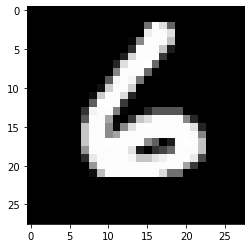

In [10]:
sample = np.random.randint(train_inputs.shape[0])

print(sample, train_labels[sample])
plt.imshow(np.reshape(train_inputs[sample], (28, 28)), cmap='gray')

In [11]:
# Define our network as a sub class of torch.nn.Module
class FCNN(torch.nn.Module):
    def __init__(self, net_param, p):
        super(FCNN, self).__init__()
        self.in_size = net_param['in_size']
        self.hidden_size = net_param['hidden_size']
        self.out_size = net_param['out_size']

        # Dropout function with probability p
        self.dropout = torch.nn.Dropout(p=p)

        self.network = torch.nn.Sequential(torch.nn.Linear(self.in_size, self.hidden_size),
                                           torch.nn.ReLU(),
                                           self.dropout,
                                           torch.nn.Linear(self.hidden_size, self.out_size))

        self.loss_fct = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.network(x)

    def loss(self, y_pred, y_true):
        return self.loss_fct(y_pred, y_true)

In [16]:
# Define the network parameters
net_param = {'in_size': 784, 'hidden_size': 128, 'out_size': 10}

net = FCNN(net_param, 0.5)

# Reset epoch count
epoch = -1

# Array to keep track of the loss after epoch
loss_log = []
val_loss_log = []

In [19]:
#Initialize optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Number of training epochs
n_epoch = 10

# Batch sized used for each update
batch_size = 100
# Number of batches per epoch
n_batchs = x_train.shape[0] // batch_size

# Create an array with all the indicies for the training data
ind = np.arange(x_train.shape[0])

# Loop over training algorithm for n_epochs
for e in range(n_epoch):
    # Increase epoch count
    epoch += 1
    # Shuffle training data indices for SGD
    shuffled_ind = np.random.permutation(ind)
    # Initialize variable to keep track of average epoch loss
    epoch_loss = 0.0
    
    # Calculate validation loss
    x_val_t = torch.autograd.Variable(x_val)
    y_val_true = torch.autograd.Variable(y_val)
    y_val_pred = net(x_val_t)
    val_loss_log.append(net.loss(y_val_pred, y_val_true).item())
    
    # Put network in training mode
    net.train()

    # Loop over training algorithm for each batch in a single epoch
    for i in range(n_batchs):
        # Collect batch of training data and labels using shuffled indicies
        x = torch.autograd.Variable(x_train[shuffled_ind[batch_size*i: batch_size*(i+1)]])
        y_true = torch.autograd.Variable(y_train[shuffled_ind[batch_size*i: batch_size*(i+1)]])

        # Set gradients to zero
        optimizer.zero_grad()

        # Propogate the training data through the network
        y_pred = net(x)

        # Calculate the loss from the network outputs
        loss = net.loss(y_pred, y_true)
        
        # Perform backpropagation
        loss.backward()
        # Update weights using backpropagation
        optimizer.step()
        # Add batch loss to epoch loss
        epoch_loss += loss.item()

    # Record the average loss for the epoch
    loss_log.append(epoch_loss / n_batchs)
    
    print('\n' + 'Epoch: ' + str(epoch) + '\n' + 'Training Loss: ' + str(loss_log[epoch]) + '\n' + 'Validation Loss: ' + str(val_loss_log[epoch]))

print('\n' + 'Training finished.')


Epoch: 10
Training Loss: 1.6908649334040555
Validation Loss: 2.2951791286468506

Epoch: 11
Training Loss: 0.8715435848452828
Validation Loss: 1.040425181388855

Epoch: 12
Training Loss: 0.6624144738370722
Validation Loss: 0.6412395238876343

Epoch: 13
Training Loss: 0.56942247569561
Validation Loss: 0.5070810317993164

Epoch: 14
Training Loss: 0.5165549782731317
Validation Loss: 0.4557746648788452

Epoch: 15
Training Loss: 0.4801034433191473
Validation Loss: 0.4106844663619995

Epoch: 16
Training Loss: 0.4501782275329937
Validation Loss: 0.3809796869754791

Epoch: 17
Training Loss: 0.4307660483230244
Validation Loss: 0.36011430621147156

Epoch: 18
Training Loss: 0.4113867425918579
Validation Loss: 0.34184420108795166

Epoch: 19
Training Loss: 0.396851071796634
Validation Loss: 0.33426570892333984

Training finished.


In [20]:
# Put network in inference mode
net.eval()

# Calculate training loss
x = torch.autograd.Variable(x_train)
y_true = torch.autograd.Variable(y_train)
y_pred = net(x)
epoch_loss = net.loss(y_pred, y_true).item()

# Calculate validation loss
x_val_t = torch.autograd.Variable(x_val)
y_val_true = torch.autograd.Variable(y_val)
y_val_pred = net(x_val)
val_loss = net.loss(y_val_pred, y_val).item()

# Calculate test loss
x_test_t = torch.autograd.Variable(x_test)
y_test_true = torch.autograd.Variable(y_test)
y_test_pred = net(x_test_t)
test_loss = net.loss(y_test_pred, y_test).item()

# Calculate model accuracy
train_values, train_indices = torch.max(y_pred, 1)
train_correct = y_true[train_indices == y_true].shape[0]

val_values, val_indices = torch.max(y_val_pred, 1)
val_correct = y_val_true[val_indices == y_val_true].shape[0]

test_values, test_indices = torch.max(y_test_pred, 1)
test_correct = y_test_true[test_indices == y_test_true].shape[0]

# Record the average loss for the epoch
print('Epoch: %d \n' % (epoch+1))
print('  Training Loss: %.4f, Accuracy: %.4f' % (epoch_loss, train_correct / y_true.shape[0]))
print('Validation Loss: %.4f, Accuracy: %.4f' % (val_loss, val_correct / y_val_true.shape[0]))
print('      Test Loss: %.4f, Accuracy: %.4f' % (test_loss, test_correct / y_test_true.shape[0]))

Epoch: 20 

  Training Loss: 0.3072, Accuracy: 0.9144
Validation Loss: 0.2408, Accuracy: 0.9384
      Test Loss: 0.2899, Accuracy: 0.9212


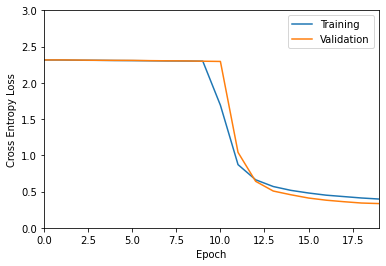

In [21]:
plt.figure()
plt.plot(np.arange(len(loss_log)), loss_log, label='Training')
plt.plot(np.arange(len(val_loss_log)), val_loss_log, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.xlim([0, len(loss_log)-1])
plt.ylim([0, 3])
plt.legend()
plt.show()

In [22]:
# Save model
torch.save(net.state_dict(), './mnist_model.pkl')

In [23]:
# Load model
net_param = {'in_size': 784, 'hidden_size': 128, 'out_size': 10}

loaded_net = FCNN(net_param, 0.5)

loaded_net.load_state_dict(torch.load('./mnist_model.pkl'))

# Put network in inference mode
loaded_net.eval()

FCNN(
  (dropout): Dropout(p=0.5, inplace=False)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss_fct): CrossEntropyLoss()
)

     True Label: 3
Predicted Label: 8


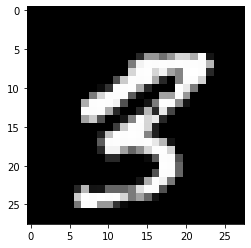

In [32]:
sample = np.random.randint(test_inputs.shape[0])

x_sample = torch.autograd.Variable(x_test[sample])
y_sample_true = torch.autograd.Variable(y_test[sample])
value, y_sample_pred = torch.max(loaded_net(x_sample), 0)
print('     True Label: %d' % (y_sample_true))
print('Predicted Label: %d' % (y_sample_pred))

plt.imshow(np.reshape(test_inputs[sample], (28, 28)), cmap='gray')